In [1]:
import torch
import os
import io
import librosa
import torchaudio
import numpy as np
import matplotlib.pyplot as plt    
from torch.utils.data import Dataset, TensorDataset, DataLoader
import glob
import pandas as pd 
from torch.utils.data import Dataset, TensorDataset, DataLoader
import torch
import librosa
from tqdm import tqdm
import matplotlib.pyplot as plt    
import numpy as np
from pathlib import Path
import torchvision
from torchvision import datasets, models, transforms
device = torch.device("cpu")

In [3]:
test_samples = list(glob.glob("/kaggle/input/birdclef-2023/test_soundscapes/*.ogg"))
test_samples
 

['/kaggle/input/birdclef-2023/test_soundscapes\\soundscape_29201.ogg']

In [9]:
waveform, sample_rate = torchaudio.load('./data/test_soundscapes/soundscape_29201.ogg')
singleChunk = (sample_rate*5)
chunksNumber = int(19200000/singleChunk)
waveform = waveform[0]

In [10]:
sample_rate = int(sample_rate)
x = [waveform[i*singleChunk : i*singleChunk + singleChunk] for i in range(0, chunksNumber)]

In [8]:
import cv2
from PIL import Image

def getImage(input: torch.Tensor):
    melspectrogram = librosa.feature.melspectrogram(y=input.numpy(), sr=sample_rate)
    fig = plt.figure(figsize=(3,2))
    plt.axis('off')  # no axis
    plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])  # Remove the white edge
    librosa.display.specshow(librosa.power_to_db(melspectrogram, ref=np.max))
    fig.canvas.draw()

    io_buf = io.BytesIO()
    fig.savefig(io_buf, format='png', dpi=128 )
    io_buf.seek(0)

    input_image = Image.open(io_buf )
    input_image = input_image.convert("RGB")
    input_image = input_image.crop((42, 14, input_image.width - 42, input_image.height - 14))
    # img = cv2.imdecode(np.frombuffer(io_buf.getvalue(), dtype=np.uint8), 1)
    # img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    io_buf.close()

    return input_image


# melspectrogram = librosa.feature.melspectrogram(y=x[99].numpy(), sr=sample_rate)

# fig = plt.figure(figsize=(3,2))
# plt.axis('off')  # no axis
# plt.axes([0., 0., 1., 1.], frameon=False, xticks=[], yticks=[])  # Remove the white edge
# librosa.display.specshow(librosa.power_to_db(melspectrogram, ref=np.max))
# fig.canvas.draw()
# # plt.savefig(to_file, bbox_inches=None, pad_inches=0)
# # data = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
# # data = data.reshape((3,) + fig.canvas.get_width_height()[::-1]  )


# io_buf = io.BytesIO()
# fig.savefig(io_buf, format='png', dpi=128 )
# io_buf.seek(0)

# input_image = Image.open(io_buf )
# input_image = input_image.convert("RGB")
# input_image = input_image.crop((42, 14, input_image.width - 42, input_image.height - 14))
# img = cv2.imdecode(np.frombuffer(io_buf.getvalue(), dtype=np.uint8), 1)
# img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
# io_buf.close()
# # print(input_image.get)

# getImage(x[99])

In [18]:
transform = transforms.Compose([ transforms.ToTensor() ])
dataset = datasets.ImageFolder('./data/test_melspectrogram/', transform=transform  )
loader = torch.utils.data.DataLoader(dataset, batch_size=2, shuffle=True)
iterator = iter(loader)



In [19]:

(X, labels) = next(iterator)
 
pred = model_ft(X) 
m = torch.nn.Softmax(dim=1)
qqq: torch.Tensor = m(pred)
print(qqq.max()) 
print(pred.argmax(1)) 
 

tensor(0.1729, grad_fn=<MaxBackward1>)
tensor([ 60, 137])


In [42]:
len(x)

120

In [20]:
img = getImage(x[100][0])
img = torchvision.transforms.functional.to_tensor( img ).unsqueeze(0)
pred = model_ft(img)
print(pred.argmax(1))

NameError: name 'x' is not defined

In [24]:
dataset[17255]

(tensor([[[0.2471, 0.1176, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.2471, 0.1176, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.2392, 0.1529, 0.0784,  ..., 0.0706, 0.0549, 0.0745],
          ...,
          [0.9725, 0.9490, 0.9529,  ..., 0.9490, 0.9490, 0.9412],
          [0.9333, 0.8784, 0.7922,  ..., 0.8745, 0.8941, 0.7843],
          [0.9333, 0.8784, 0.7922,  ..., 0.8745, 0.8941, 0.7843]],
 
         [[0.0588, 0.0667, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0588, 0.0667, 0.0000,  ..., 0.0000, 0.0000, 0.0078],
          [0.0588, 0.0706, 0.0549,  ..., 0.0510, 0.0431, 0.0510],
          ...,
          [0.4549, 0.3843, 0.3961,  ..., 0.3843, 0.3922, 0.3725],
          [0.3569, 0.2980, 0.2431,  ..., 0.2902, 0.3098, 0.2431],
          [0.3569, 0.2980, 0.2431,  ..., 0.2902, 0.3098, 0.2431]],
 
         [[0.4471, 0.2863, 0.0157,  ..., 0.0157, 0.0157, 0.0510],
          [0.4471, 0.2863, 0.0157,  ..., 0.0157, 0.0157, 0.0510],
          [0.4431, 0.3451, 0.2118,  ...,

tensor([190])
tensor([190])
tensor([190])
tensor([190])
tensor([190])
tensor([190])
tensor([190])


KeyboardInterrupt: 

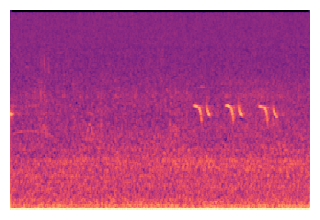

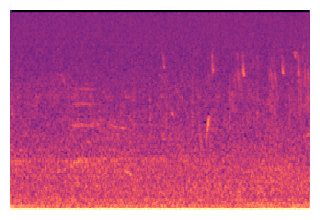

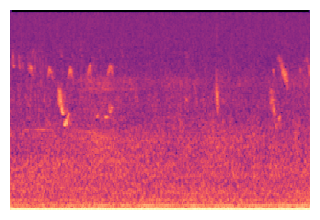

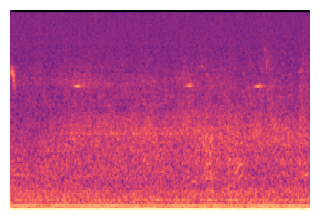

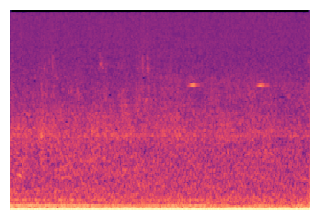

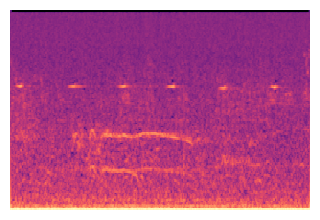

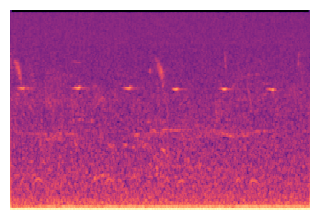

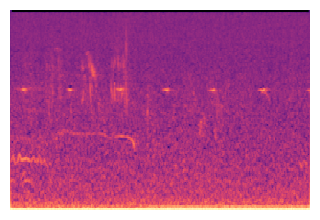

In [15]:
for i in x:
    img = getImage(i)
    img = torchvision.transforms.functional.to_tensor(
        img
    ).unsqueeze(0)
    pred = model_ft(img)
    print(pred.argmax(1))